# 【第1回_Beginner限定コンペ】銀行の顧客ターゲティング

顧客の属性情報などから定期預金キャンペーンの反応率を予測しよう。

https://signate.jp/competitions/292

LightGBM編

## ライブラリインポート

In [328]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#import lightgbm as lgb
from optuna.integration import lightgbm as lgb
#import featuretools as ft

#from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

## データ読み込み・前処理

In [329]:
#train_df = pd.read_csv('train.csv')
#test_df = pd.read_csv('test.csv')

# poutcome の前処理済みファイルを使う
train_df = pd.read_csv('y_train-Copy1.csv')
test_df = pd.read_csv('y_test-Copy1.csv')
train2_df = pd.read_csv('y_train-Copy2.csv')
test2_df = pd.read_csv('y_test-Copy2.csv')
train3_df = pd.read_csv('y_train-Copy3.csv')
test3_df = pd.read_csv('y_test-Copy3.csv')

submit_df = pd.read_csv('submit_sample.csv', header=None)

In [330]:
print(train_df.shape)
print(test_df.shape)

(27100, 17)
(18050, 16)


In [331]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27100 entries, 0 to 27099
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   age        27100 non-null  int64  
 1   job        27100 non-null  int64  
 2   marital    27100 non-null  int64  
 3   education  27100 non-null  int64  
 4   balance    27100 non-null  int64  
 5   housing    27100 non-null  int64  
 6   loan       27100 non-null  int64  
 7   contact    27100 non-null  int64  
 8   day        27100 non-null  int64  
 9   month      27100 non-null  int64  
 10  duration   27100 non-null  float64
 11  campaign   27100 non-null  int64  
 12  pdays      27100 non-null  int64  
 13  previous   27100 non-null  int64  
 14  days       27100 non-null  int64  
 15  poutcome   27100 non-null  float64
 16  y          27100 non-null  float64
dtypes: float64(3), int64(14)
memory usage: 3.5 MB


In [332]:
train_df.head()

,age,job,marital,education,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,days,poutcome,y
0,32,6,0,2,7958,0,0,1,28,9,4.624973,1,525,0,307,1.0,0.0
1,35,7,2,3,32146,0,0,1,11,7,4.624973,1,565,0,228,1.0,0.0
2,33,7,2,2,-598,0,0,1,9,2,4.624973,3,170,1,71,1.0,0.0
3,32,2,0,2,87009,0,0,1,30,1,4.624973,1,518,2,61,1.0,0.0
4,33,6,2,2,87455,1,0,1,20,6,6.717805,2,504,0,206,1.0,0.0


In [333]:
test_df.head()

,age,job,marital,education,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,days,poutcome
0,35,2,0,2,89043,0,0,1,7,2,4.624973,2,184,2,69,1.0
1,35,2,2,3,68831,1,0,1,13,2,4.624973,1,708,2,75,1.0
2,30,10,0,3,80315,0,0,2,12,2,4.624973,1,471,1,74,1.0
3,31,9,0,3,2006,0,0,1,12,6,6.717805,2,369,2,198,1.0
4,40,6,1,3,34525,0,0,1,17,4,4.770685,1,29,1,141,1.0


In [334]:
train_df.describe()

,age,job,marital,education,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,days,poutcome,y
count,27100.000000,27100.000000,27100.000000,27100.000000,27100.000000,27100.000000,27100.000000,27100.000000,27100.000000,27100.000000,27100.000000,27100.000000,27100.000000,27100.000000,27100.000000,27100.000000,27100.000000
mean,36.073284,5.152509,1.386162,2.046125,47682.901771,0.583727,0.127269,0.788007,16.700443,6.003542,5.154210,1.775830,432.482399,0.085720,202.810258,0.098102,0.077934
std,7.816417,2.669990,0.872384,0.727044,31650.760036,0.492949,0.333281,0.498535,8.576252,2.135158,0.772170,0.950045,252.150648,0.365889,66.135046,0.153382,0.268072
min,22.000000,2.000000,0.000000,0.000000,-6847.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,-1.000000,0.000000,34.000000,0.000000,0.000000
25%,31.000000,3.000000,0.000000,2.000000,20015.750000,0.000000,0.000000,0.000000,8.000000,5.000000,4.804021,1.000000,214.000000,0.000000,170.000000,0.019677,0.000000
50%,33.000000,5.000000,2.000000,2.000000,47624.000000,1.000000,0.000000,1.000000,17.000000,5.000000,5.068904,1.000000,432.000000,0.000000,182.000000,0.048988,0.000000
75%,37.000000,7.000000,2.000000,2.000000,75330.000000,1.000000,0.000000,1.000000,26.000000,7.000000,5.846439,2.000000,650.000000,0.000000,234.000000,0.119095,0.000000
max,90.000000,12.000000,2.000000,3.000000,102121.000000,1.000000,1.000000,2.000000,31.000000,12.000000,8.031710,5.000000,870.000000,3.000000,373.000000,1.000000,1.000000


In [335]:
test_df.describe()

,age,job,marital,education,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,days,poutcome
count,18050.000000,18050.000000,18050.000000,18050.000000,18050.000000,18050.000000,18050.000000,18050.000000,18050.000000,18050.000000,18050.000000,18050.000000,18050.000000,18050.000000,18050.000000,18050.000000
mean,36.104266,5.120388,1.382161,2.039501,47158.451801,0.577175,0.128587,0.783989,16.697950,5.998726,5.149830,1.770083,436.171801,0.090859,202.658449,0.098315
std,7.863805,2.650421,0.873514,0.717774,31469.525699,0.494022,0.334752,0.504881,8.580203,2.118452,0.781723,0.944872,251.392519,0.375801,65.583220,0.153434
min,20.000000,1.000000,0.000000,0.000000,-6838.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,-1.000000,0.000000,34.000000,0.000000
25%,31.000000,3.000000,0.000000,2.000000,19654.500000,0.000000,0.000000,0.000000,8.000000,5.000000,4.804021,1.000000,219.250000,0.000000,170.000000,0.020093
50%,33.000000,5.000000,2.000000,2.000000,46886.000000,1.000000,0.000000,1.000000,17.000000,5.000000,5.068904,1.000000,436.000000,0.000000,182.000000,0.049251
75%,37.000000,7.000000,2.000000,2.000000,74178.000000,1.000000,0.000000,1.000000,26.000000,7.000000,5.846439,2.000000,654.000000,0.000000,234.000000,0.118465
max,90.000000,12.000000,2.000000,3.000000,102124.000000,1.000000,1.000000,2.000000,31.000000,12.000000,8.031710,4.000000,870.000000,3.000000,373.000000,1.000000


In [336]:
train_df.isnull().any()

age          False
job          False
marital      False
education    False
balance      False
housing      False
loan         False
contact      False
day          False
month        False
duration     False
campaign     False
pdays        False
previous     False
days         False
poutcome     False
y            False
dtype: bool

In [337]:
test_df.isnull().any()

age          False
job          False
marital      False
education    False
balance      False
housing      False
loan         False
contact      False
day          False
month        False
duration     False
campaign     False
pdays        False
previous     False
days         False
poutcome     False
dtype: bool

In [338]:
# job のラベリングを y の平均の低い順にしてみる
#train_df.groupby('job').mean().sort_values('y')

データメモ

- testデータの `job` に `unknown` が一人いる (trainデータにはいない)

In [339]:
# one hot encoding
#train_df = pd.get_dummies(train_df, columns=['job', 'marital', 'education', 'contact', 'poutcome'])
#test_df = pd.get_dummies(test_df, columns=['job', 'marital', 'education', 'contact', 'poutcome'])
#test_df.drop(['job_unknown'], axis=1, inplace=True)

#df_list = [train_df, test_df]

train_df['poutcome'] = (train_df['poutcome'] + train2_df['poutcome'] + train3_df['poutcome']) / 3
test_df['poutcome'] = (test_df['poutcome'] + test2_df['poutcome'] + test3_df['poutcome']) / 3

#job_encoder = LabelEncoder()
#job_encoder.fit(test_df['job'])

#for df in df_list:
    #df['job'] = job_encoder.transform(df['job'])
    #df['job'] = df['job'].map({'unknown': 1, 'technician': 2, 'blue-collar': 3, 'services': 4, 'entrepreneur': 5, 'admin.': 6, 'management': 7, 'housemaid': 8, 'self-employed': 9, 'unemployed': 10, 'retired': 11, 'student': 12})

    #df['marital'] = df['marital'].map({'married': 2, 'divorced':1, 'single': 0})
    #df.drop(['marital'], axis=1, inplace=True)

    #df['education'] = df['education'].map({'tertiary': 3, 'secondary': 2, 'primary': 1, 'unknown': 0})
    #df.drop(['education'], axis=1, inplace=True)

    #df['default'] = df['default'].map({'yes': 1, 'no': 0})
    #df.drop(['default'], axis=1, inplace=True)

    #df['housing'] = df['housing'].map({'yes': 1, 'no': 0})
    #df.drop(['housing'], axis=1, inplace=True)
    
    #df['loan'] = df['loan'].map({'yes': 1, 'no': 0})
    #df.drop(['loan'], axis=1, inplace=True)

    #df['contact'] = df['contact'].map({'telephone': 2, 'cellular': 1, 'unknown': 0})
    #df.drop(['contact'], axis=1, inplace=True)

    #df['poutcome'] = df['poutcome'].map({'success': 3, 'unknown': 2, 'failure': 1, 'other': 1})
    
    #df['month'] = df['month'].map({'jan': 1, 'feb': 2, 'mar': 3, 'apr': 4, 'may': 5, 'jun': 6, 'jul': 7, 'aug': 8, 'sep': 9, 'oct': 10, 'nov': 11, 'dec': 12})
    #df.drop(['day', 'month'], axis=1, inplace=True)
    
    # Feb 30 とかあって、正確には変換できない
    # → データの Feb 30 を Mar 1 に変換した(他にも、 2/31, 6/31, 11/31)
    #df['days'] = pd.to_datetime('2016/' + df['month'].astype(str).str.pad(2,fillchar='0') + '/' + df['day'].astype(str).str.pad(2,fillchar='0'), format='%Y/%m/%d').dt.strftime('%j')
    #df['days'] = df['month'] * 31 + df['day']
    
    #df['duration'] = np.log(df['duration'] + 1)
    
    #df.drop(['id'], axis=1, inplace=True)
    
# featuretools用
#y = train_df.pop('y')
#train_df['train'] = 1
#test_df['train'] = 0
#test_df['id'] = test_df['id'] + len(train_df)

In [340]:
#train_df.head()

In [341]:
#test_df.head()

In [342]:
train_df.describe()

,age,job,marital,education,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,days,poutcome,y
count,27100.000000,27100.000000,27100.000000,27100.000000,27100.000000,27100.000000,27100.000000,27100.000000,27100.000000,27100.000000,27100.000000,27100.000000,27100.000000,27100.000000,27100.000000,27100.000000,27100.000000
mean,36.073284,5.152509,1.386162,2.046125,47682.901771,0.583727,0.127269,0.788007,16.700443,6.003542,5.154210,1.775830,432.482399,0.085720,202.810258,0.094374,0.077934
std,7.816417,2.669990,0.872384,0.727044,31650.760036,0.492949,0.333281,0.498535,8.576252,2.135158,0.772170,0.950045,252.150648,0.365889,66.135046,0.146877,0.268072
min,22.000000,2.000000,0.000000,0.000000,-6847.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,-1.000000,0.000000,34.000000,0.000000,0.000000
25%,31.000000,3.000000,0.000000,2.000000,20015.750000,0.000000,0.000000,0.000000,8.000000,5.000000,4.804021,1.000000,214.000000,0.000000,170.000000,0.023177,0.000000
50%,33.000000,5.000000,2.000000,2.000000,47624.000000,1.000000,0.000000,1.000000,17.000000,5.000000,5.068904,1.000000,432.000000,0.000000,182.000000,0.050222,0.000000
75%,37.000000,7.000000,2.000000,2.000000,75330.000000,1.000000,0.000000,1.000000,26.000000,7.000000,5.846439,2.000000,650.000000,0.000000,234.000000,0.114844,0.000000
max,90.000000,12.000000,2.000000,3.000000,102121.000000,1.000000,1.000000,2.000000,31.000000,12.000000,8.031710,5.000000,870.000000,3.000000,373.000000,1.000000,1.000000


In [343]:
test_df.describe()

,age,job,marital,education,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,days,poutcome
count,18050.000000,18050.000000,18050.000000,18050.000000,18050.000000,18050.000000,18050.000000,18050.000000,18050.000000,18050.000000,18050.000000,18050.000000,18050.000000,18050.000000,18050.000000,18050.000000
mean,36.104266,5.120388,1.382161,2.039501,47158.451801,0.577175,0.128587,0.783989,16.697950,5.998726,5.149830,1.770083,436.171801,0.090859,202.658449,0.094577
std,7.863805,2.650421,0.873514,0.717774,31469.525699,0.494022,0.334752,0.504881,8.580203,2.118452,0.781723,0.944872,251.392519,0.375801,65.583220,0.146711
min,20.000000,1.000000,0.000000,0.000000,-6838.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,-1.000000,0.000000,34.000000,0.000000
25%,31.000000,3.000000,0.000000,2.000000,19654.500000,0.000000,0.000000,0.000000,8.000000,5.000000,4.804021,1.000000,219.250000,0.000000,170.000000,0.023810
50%,33.000000,5.000000,2.000000,2.000000,46886.000000,1.000000,0.000000,1.000000,17.000000,5.000000,5.068904,1.000000,436.000000,0.000000,182.000000,0.051072
75%,37.000000,7.000000,2.000000,2.000000,74178.000000,1.000000,0.000000,1.000000,26.000000,7.000000,5.846439,2.000000,654.000000,0.000000,234.000000,0.114490
max,90.000000,12.000000,2.000000,3.000000,102124.000000,1.000000,1.000000,2.000000,31.000000,12.000000,8.031710,4.000000,870.000000,3.000000,373.000000,1.000000


In [323]:
# featuretools による総当り特徴量生成

#df = pd.concat([train_df, test_df])

#es = ft.EntitySet(id='bank')
#es.entity_from_dataframe(entity_id='bank', dataframe=df, index='id')
#feature_matrix, feature_defs = ft.dfs(
#    entityset=es,
#    target_entity='bank',
#    trans_primitives=['subtract_numeric'],
#    agg_primitives=[],
#    max_depth=1,
#)

#df_dict = {}
#for name, group in feature_matrix.groupby('train'):
#    df_dict[name] = group
    
#train_df = df_dict[1]
#test_df = df_dict[0]

#train_df.drop(['train'], axis=1, inplace=True)
#test_df.drop(['train'], axis=1, inplace=True)


In [324]:
#train_df.head()

In [325]:
#test_df.head()

In [326]:
#train_df.info()

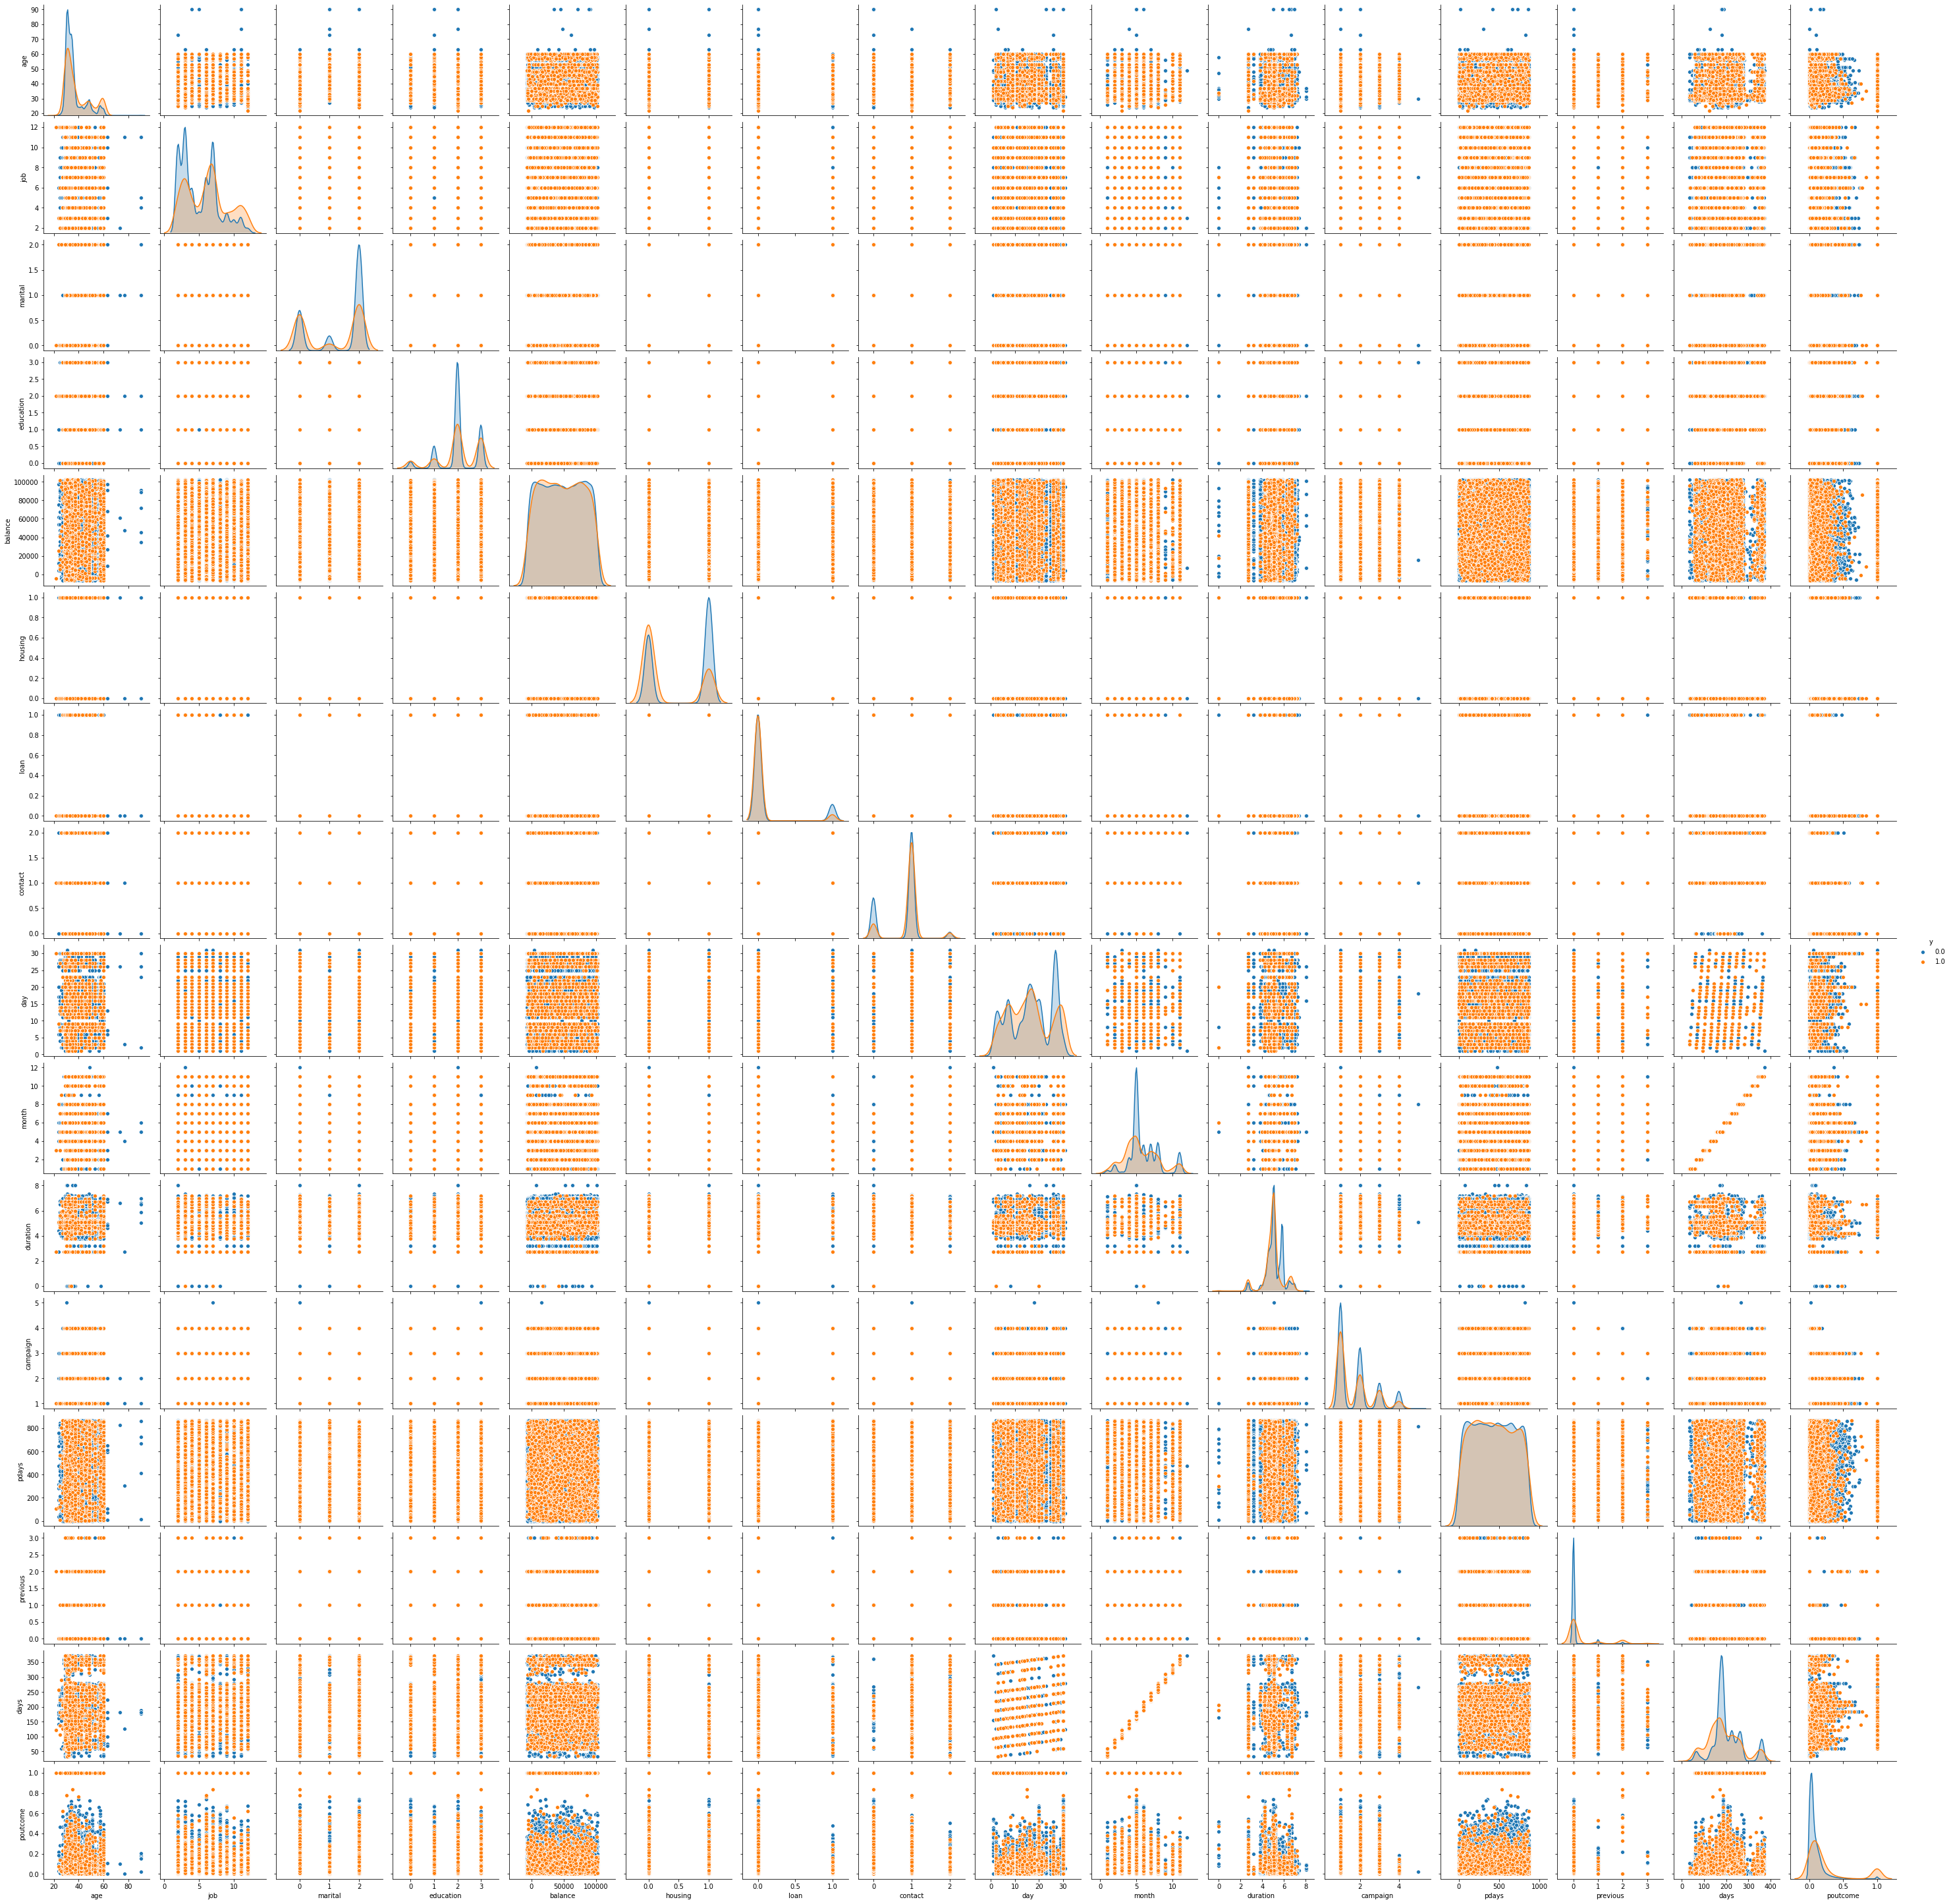

In [327]:
#train_pg = sns.pairplot(train_df.drop(['month', 'day'], axis=1), hue='y')
train_pg = sns.pairplot(train_df, hue='y')
train_pg.savefig('train_df.png')

#test_pg = sns.pairplot(test_df)
#test_pg.savefig('test_df.png')

## 学習準備

In [299]:
y = train_df.pop('y')

X_train, X_test, y_train, y_test = train_test_split(train_df, y, test_size=0.2, random_state=77)

train_data = lgb.Dataset(data=X_train, label=y_train, free_raw_data=False)
test_data = lgb.Dataset(data=X_test, label=y_test, free_raw_data=False)
final_train_set = lgb.Dataset(data=train_df, label=y, free_raw_data=False)

## ハイパーパラメータ

In [300]:
lgb_params = {
    'boosting': 'dart',          # dart (drop out trees) often performs better
    'application': 'binary',     # Binary classification
    'metric': 'binary_logloss',  # Area under ROC curve as the evaulation metric
    # 以下はoptunaでチューニングする
    #'learning_rate': 0.05,       # Learning rate, controls size of a gradient descent step
    #'min_data_in_leaf': 20,      # Data set is quite small so reduce this a bit
    #'feature_fraction': 0.7,     # Proportion of features in each boost, controls overfitting
    #'num_leaves': 41,            # Controls size of tree since LGBM uses leaf wise splits
    #'drop_rate': 0.15
}

## 学習

In [301]:
evaluation_results = {}

clf = lgb.train(
    train_set=train_data,
    params=lgb_params,
    valid_sets=[train_data, test_data], 
    valid_names=['Train', 'Test'],
    evals_result=evaluation_results,
    num_boost_round=1000,
    verbose_eval=0
)
optimum_boost_rounds = clf.best_iteration

print('Result:')
print(clf.params)
print(clf.best_score)

min_data_in_leaf, val_score: 0.197622: 100%|##########| 5/5 [00:12<00:00,  2.47s/it]


Result:
{'boosting': 'dart', 'application': 'binary', 'metric': 'binary_logloss', 'lambda_l1': 6.346533770614673e-05, 'lambda_l2': 1.8767915840708323e-05, 'num_leaves': 5, 'feature_fraction': 0.6, 'bagging_fraction': 0.5835755272481117, 'bagging_freq': 5, 'min_child_samples': 20}
defaultdict(<class 'collections.OrderedDict'>, {'Train': OrderedDict([('binary_logloss', 0.1817971655492392)]), 'Test': OrderedDict([('binary_logloss', 0.1976216467076976)])})


## 可視化

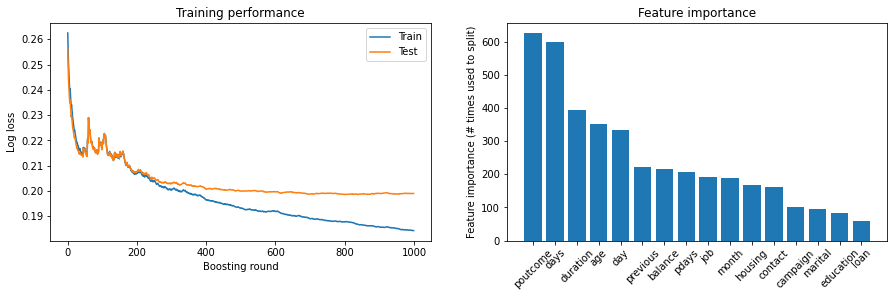

In [302]:
fig, axs = plt.subplots(1, 2, figsize=[15, 4])

# Plot the log loss during training
axs[0].plot(evaluation_results['Train']['binary_logloss'], label='Train')
axs[0].plot(evaluation_results['Test']['binary_logloss'], label='Test')
axs[0].set_ylabel('Log loss')
axs[0].set_xlabel('Boosting round')
axs[0].set_title('Training performance')
axs[0].legend()

# Plot feature importance
importances = pd.DataFrame({'features': clf.feature_name(), 
                            'importance': clf.feature_importance()}).sort_values('importance', ascending=False)
axs[1].bar(x=np.arange(len(importances)), height=importances['importance'])
axs[1].set_xticks(np.arange(len(importances)))
axs[1].set_xticklabels(importances['features'], rotation = 45)
axs[1].set_ylabel('Feature importance (# times used to split)')
axs[1].set_title('Feature importance')

plt.show()

In [303]:
importances.sort_values('importance')

,features,importance
6,loan,60
3,education,83
2,marital,96
11,campaign,100
7,contact,163
5,housing,168
9,month,188
1,job,192
12,pdays,207
4,balance,217


In [304]:
preds = np.round(clf.predict(X_test))
print('Accuracy score = \t {}'.format(accuracy_score(y_test, preds)))
print('Precision score = \t {}'.format(precision_score(y_test, preds)))
print('Recall score =   \t {}'.format(recall_score(y_test, preds)))
print('F1 score =      \t {}'.format(f1_score(y_test, preds)))

Accuracy score = 	 0.933579335793358
Precision score = 	 0.7280701754385965
Recall score =   	 0.20145631067961164
F1 score =      	 0.3155893536121673


## 推論

In [305]:
test_pred = clf.predict(test_df, num_iteration=optimum_boost_rounds)

In [306]:
submit_df[1] = test_pred
submit_df.to_csv('submit.csv', header=False, index=False)